In [29]:
import networkx as nx 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np 
from scipy.stats import linregress
import math
import json
import subprocess
import pickle
from itertools import combinations, product

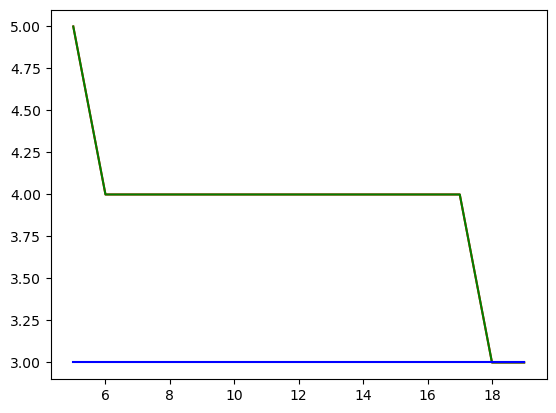

In [2]:
def calculate_density1(k, n):
    return math.ceil(k / (3 - 6/n))

def calculate_density2(k, n):
    return math.floor((k + 3 - 7/n) / (3 - 6/n))

def calculate_density(k):
    return math.ceil((k+1) / 3)

n = list(range(5, 20))
k = 8

y1 = [calculate_density1(k, i) for i in n]
y2 = [calculate_density2(k, i) for i in n]
y3 = [calculate_density(k) for i in n]

plt.plot(n, y1, label='Density 1', color='red')
plt.plot(n, y2, label='Density 2', color='green')
plt.plot(n, y3, label='Density', color='blue')

plt.show()

In [3]:
def random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [4]:
def barabasi_albert_graph(n, m, embedding_layers_number, seed=None, initial_graph=None):
    """Returns a random graph using Barabási-Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási-Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási-Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási-Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    for index, edge in enumerate(G.edges()):
        G.edges[edge]['color'] = 'blue' if index % embedding_layers_number == 0 else 'red'

    if seed is None:
        seed = np.random.RandomState()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

In [5]:
def load_graph_from_file(file_path: str):
    """Load a graph from a file.

    Parameters
    ----------
    file_path : str
        The path to the file.
    """

    with open(file_path, 'r') as f:
        data = json.load(f)

    G = nx.Graph()

    for node in data['nodes']:
        if 'id' in node and 'color' in node:
            G.add_node(node['id'], color=node['color'])
        elif 'id' in node:
            G.add_node(node['id'])

    for edge in data['edges']:
        if 'source' in edge and 'target' in edge and 'color' in edge:
            G.add_edge(edge['source'], edge['target'], color=edge['color'])
        elif 'source' in edge and 'target' in edge:
            G.add_edge(edge['source'], edge['target'])

    return G

In [6]:
def generate_graph(initial_nodes: int, final_nodes: int, edges_per_node: int):
    filename = 'graph.json'
    subprocess.run(['./generategraph', str(initial_nodes), str(edges_per_node), str(final_nodes), filename])
    return load_graph_from_file(filename)

In [7]:
def draw_graph(G: nx.Graph, only_properties = False, name: str = 'BA Graph', pos: dict = None, hist_max_deg: int = None):
    """Draw a graph with node and edge colors.

    Parameters
    ----------
    G : nx.Graph
        The graph to draw.
    """

    fig = plt.figure(figsize=(14, 7))
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[:, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[1, 2])

    if not only_properties:
        node_colors = [G.nodes[node]['color'] if 'color' in G.nodes[node] else 'black' for node in G.nodes()]
        edge_colors = [G.edges[edge]['color'] if 'color' in G.edges[edge] else 'black' for edge in G.edges()]
        if pos == None:
            pos = nx.kamada_kawai_layout(G)
        nx.draw(G, pos, ax=ax0, node_color=node_colors, node_size=50, edge_color=edge_colors, with_labels=False)
        ax0.set_title(name)

    degrees = [G.degree(n) for n in G.nodes()]

    if hist_max_deg == None:
        hist_max_deg = max(degrees) + 2
    ax1.hist(degrees, bins=range(1, hist_max_deg), align='left', color='deepskyblue')
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")

    degree_counts = np.bincount(degrees)[1:]
    cdf = np.cumsum(degree_counts[::-1])[::-1]
    cdf = cdf / cdf[0]

    nonzero_indices = degree_counts > 0
    k = np.arange(1, len(degree_counts) + 1)[nonzero_indices]
    cdf = cdf[nonzero_indices]

    log_k = np.log(k)
    log_cdf = np.log(cdf)

    slope, intercept, r_value, p_value, std_err = linregress(log_k, log_cdf)
    lambda_estimate = -slope

    ax2.scatter(k, cdf, s=10, alpha=0.75, label='Degree CDF', color='deepskyblue')
    ax2.plot(k, np.exp(intercept) * k ** slope, label=f'Power-law fit: $\\lambda = {lambda_estimate:.2f}$', color='deeppink')

    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Degree')
    ax2.set_ylabel('CDF')
    ax2.set_title('Degree Distribution and Power-law Fit')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return pos, hist_max_deg

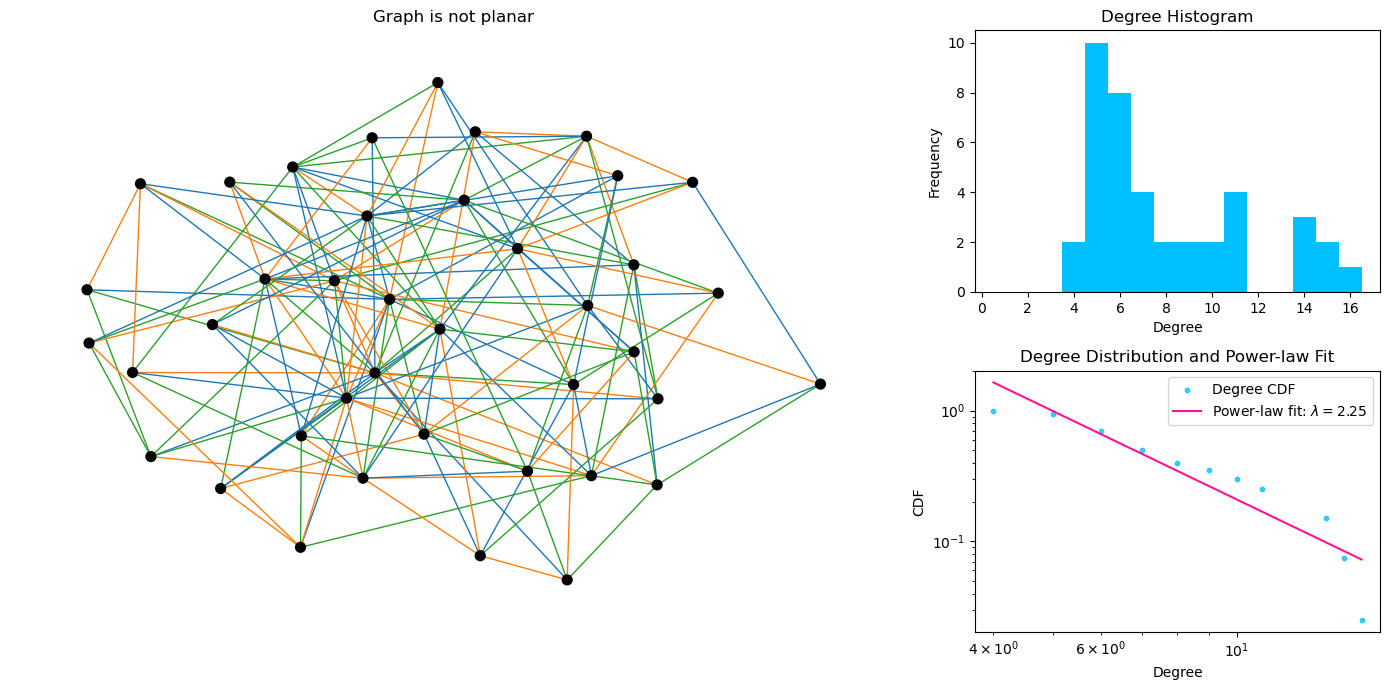

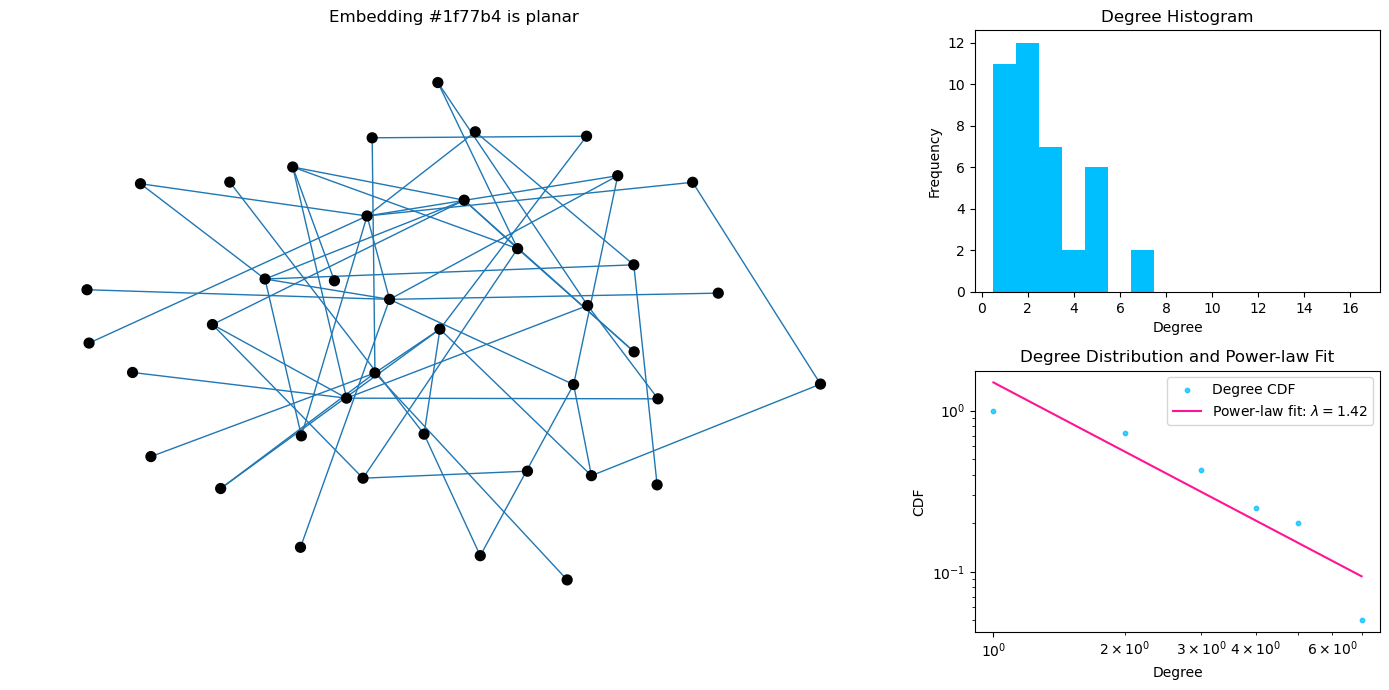

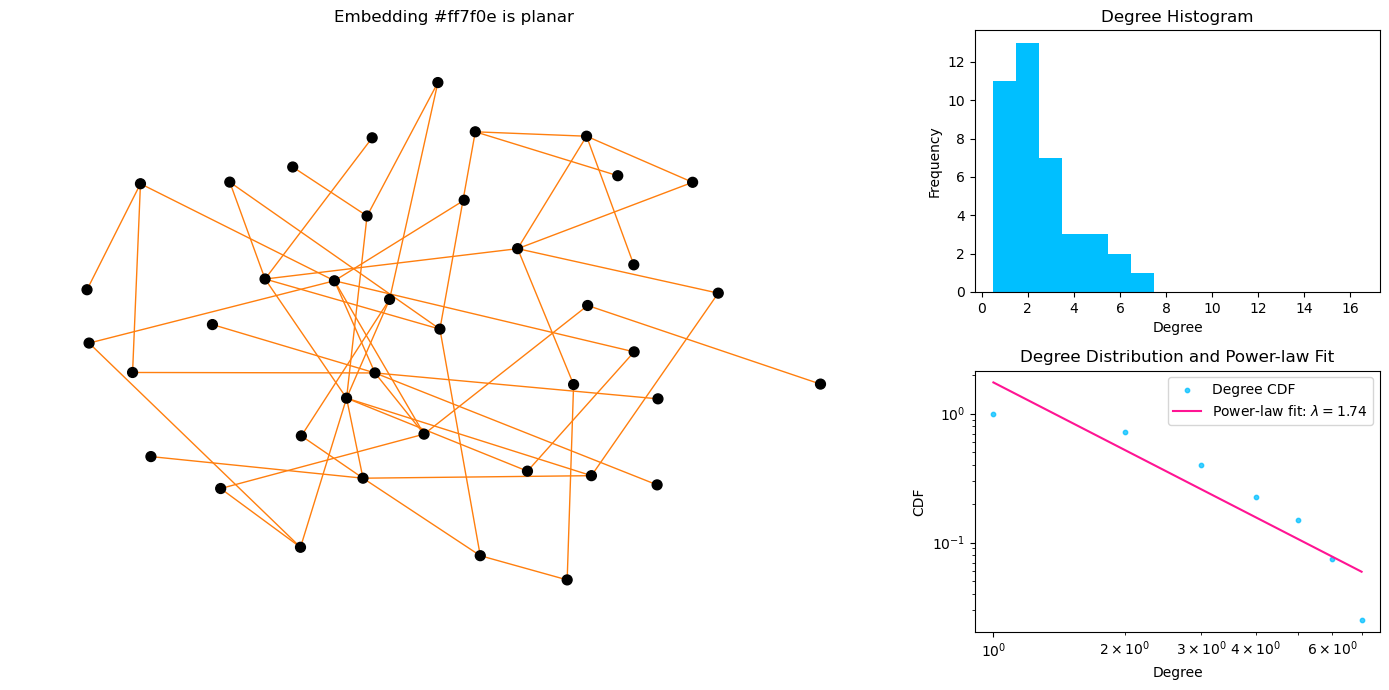

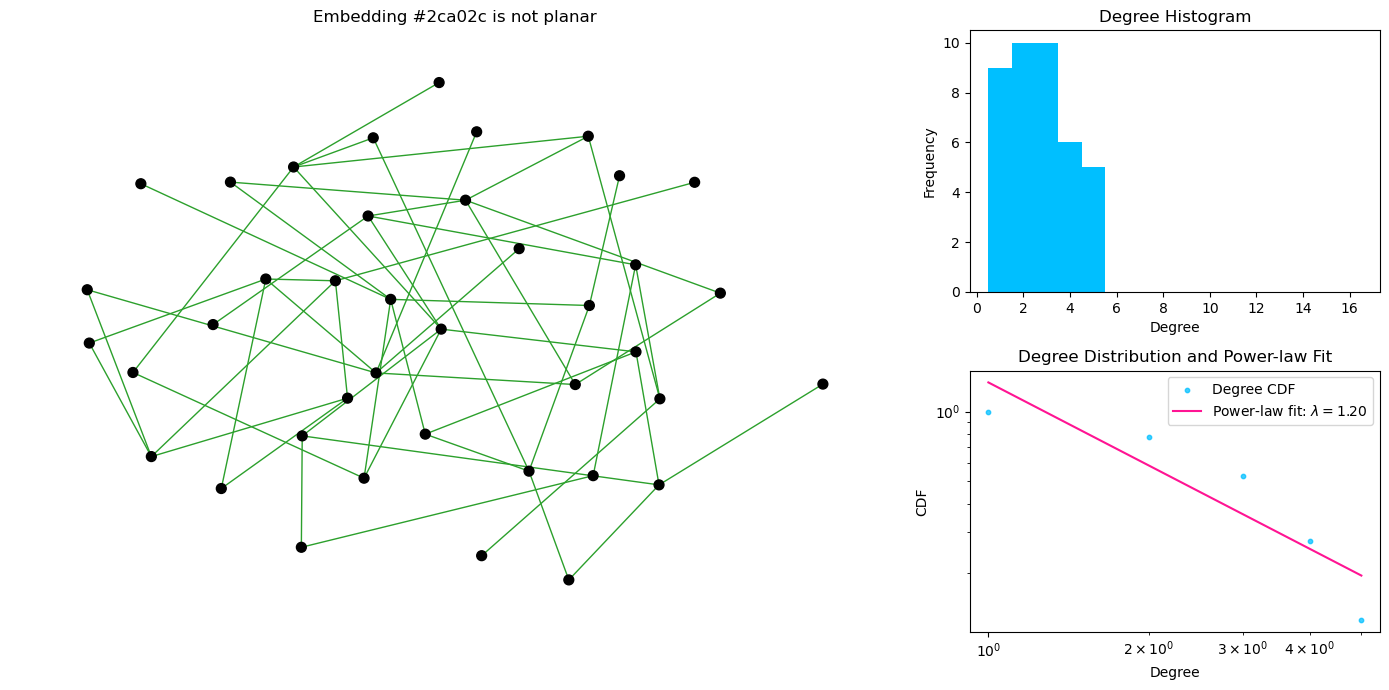

In [9]:
GRAPH_PATH = 'cmake-build-debug/graph1.txt'
EMBEDDING_PATHS = [
    'cmake-build-debug/embedding_#1f77b4.txt',
    'cmake-build-debug/embedding_#ff7f0e.txt',
    'cmake-build-debug/embedding_#2ca02c.txt',
    'cmake-build-debug/embedding_#d62728.txt',
    'cmake-build-debug/embedding_#9467bd.txt',
]
EMBEDDING_NUMBERS = 3

ba = load_graph_from_file('cmake-build-debug/graph1.txt')

planar_info = 'is planar' if nx.is_planar(ba) else 'is not planar'
pos, hist_max_deg = draw_graph(ba, False, 'Graph ' + planar_info, None, None)

for index, embb_path in enumerate(EMBEDDING_PATHS[:EMBEDDING_NUMBERS]):
    embb = load_graph_from_file(embb_path)
    planar_info = ' is planar' if nx.is_planar(embb) else ' is not planar'
    draw_graph(embb, False, 'Embedding ' + embb_path.split('_')[-1][:-4] + planar_info, pos, hist_max_deg)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
[89, 94, 116, 138, 164, 209, 238, 283, 474, 388, 423, 441, 419, 427, 461, 483, 531, 634, 591, 580, 622, 749, 677, 795, 836, 826, 813, 896, 1517, 2122, 1938, 1452, 1455, 2700, 2451, 2564, 1727, 1734, 1913, 2266, 2372, 2013, 3849, 4185, 3605, 4250, 2402, 2420, 5138, 6708, 4748, 4169, 5926, 8210, 7650, 6599, 

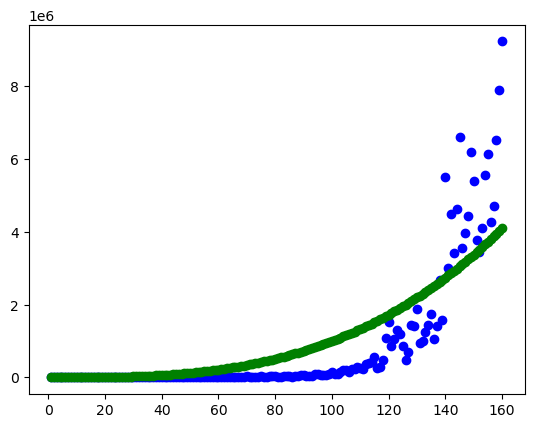

In [13]:
with open('cmake-build-debug/times1.txt') as file:
    xs = []
    ys1 = []
    ys2 = []
    for line in file.readlines():
        x, y = line.strip().split()
        xs.append(int(x))
        ys1.append(int(y))
        ys2.append(1 * int(x) ** 3)
        # ys2.append(3 ** (int(x) / 10))
        # ys2.append(int(y) / int(x) ** 3)

    print(xs)
    print(ys1)
    print(ys2)

    plt.scatter(xs, ys1, c='blue')
    plt.scatter(xs, ys2, c='green')
    # plt.scatter(xs[20:], ys2[20:])
    # plt.scatter(xs, ys1, c="red")
    # plt.scatter(xs, [x ** 3 for x in xs], c="green")
    # plt.scatter(xs, [0.002 * x ** 4 for x in xs], c="blue")
    plt.show()

In [ ]:
# Checking density of neighbours of nodes with high degree

REPEATS = 10

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 10
NEIGHBOURS_NUMBER_STEP = 1

INITIAL_NODES = 10
FINAL_NODES_LOW = 100
FINAL_NODES_HIGH = 10500
FINAL_NODES_STEP = 500
EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 10
EDGES_PER_NODE_STEP = 1

max_deg_data = {}
density_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    max_deg_data_per_nn = {}
    density_data_per_nn = {}
    for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH + 1, EDGES_PER_NODE_STEP):
        print(f'm = {m}')
        graph_size = []
        max_deg = []
        avg_deg = []
        for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH + 1, FINAL_NODES_STEP):
            max_deg_sum = 0
            avg_deg_sum = 0
            for _ in range(REPEATS):
                graph = generate_graph(INITIAL_NODES, n, m)

                degree_dict = dict(graph.degree())
                top_degree_node = max(degree_dict, key=degree_dict.get)

                # subgraph_nodes = [top_degree_node] + list(graph.neighbors(top_degree_node))
                # subgraph = graph.subgraph(subgraph_nodes)

                nodes_within_k_distance = nx.single_source_shortest_path_length(graph, top_degree_node, cutoff=nn)
                subgraph_nodes = list(nodes_within_k_distance.keys())
                subgraph = graph.subgraph(subgraph_nodes)

                # for node in subgraph_nodes:
                #     graph.nodes[node]['color'] = 'blue'
                # graph.nodes[top_degree_node]['color'] = 'green'
                # draw_graph(graph, False, f'm = {m}, n = {n}')

                max_deg_sum += graph.degree(top_degree_node)
                avg_deg_sum += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            
            graph_size.append(n)
            max_deg.append(max_deg_sum / REPEATS)
            avg_deg.append(avg_deg_sum / REPEATS)

        max_deg_data_per_nn[m] = {'graph_size': graph_size, 'max_deg': max_deg}
        density_data_per_nn[m] = {'graph_size': graph_size, 'avg_deg': avg_deg}

    max_deg_data[nn] = max_deg_data_per_nn
    density_data[nn] = density_data_per_nn

with open('neighbour-max-deg.pkl', 'wb') as f:
    pickle.dump(max_deg_data, f)

with open('neighbour-density.pkl', 'wb') as f:
    pickle.dump(density_data, f)

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

with open('neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

with open('neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

# for nn in nn_values:
#     for m in m_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for nn in nn_values:
#     for m in m_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'm = {m}', color=COLORS[m - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for neighbour size = " + str(nn))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         plt.plot(density_data[nn][m]['graph_size'], density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

# for m in m_values:
#     for nn in nn_values:
#         edges_number = [n * m for n in density_data[nn][m]['graph_size']]
#         plt.plot(edges_number, density_data[nn][m]['avg_deg'], label=f'nn = {nn}', color=COLORS[nn - 1])
#     plt.title(r"$|E_0|$ vs $\frac{|E|}{|V|}$ for edges per node = " + str(m))
#     plt.legend()
#     plt.show()

for nn in nn_values:
    x = []
    y = []
    for m in m_values:
        x.extend([m] * len(density_data[nn][m]['avg_deg']))
        y.extend([d/m for d in density_data[nn][m]['avg_deg']])
    plt.scatter(x, y, label=f'nn = {nn}')
plt.title(r"edges per node vs $\frac{|E|}{|V| \cdot m}$")
plt.legend(loc='upper right')
plt.show()

for m in m_values:
    x = []
    y = []
    for nn in nn_values:
        x.extend([nn] * len(density_data[nn][m]['avg_deg']))
        y.extend(density_data[nn][m]['avg_deg'])
    plt.scatter(x, y, label=f'm = {m}')
plt.title(r"neighbour size vs $\frac{|E|}{|V|}$")
plt.legend(loc='upper right')
plt.show()

# nn_vals = []
# m_vals = []
# y_vals = []
# for nn in nn_values:
#     for m in m_values:
#         for i in range(len(density_data[nn][m]['graph_size'])):
#             nn_vals.append(nn)
#             m_vals.append(m)
#             y_vals.append(density_data[nn][m]['avg_deg'][i])

# plt.scatter(m_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs edges per node")
# plt.show()

# plt.scatter(nn_vals, y_vals)
# plt.title(r"$\frac{|E|}{|V|}$ vs neighbour size")
# plt.show()


In [ ]:
MAX_DEG_X_FUN = lambda nn, m, n, max_deg: n
MAX_DEG_Y_FUN = lambda nn, m, n, max_deg: max_deg / math.sqrt(n)

with open('neighbour-max-deg.pkl', 'rb') as f:
    max_deg_data = pickle.load(f)

nn_values = list(max_deg_data.keys())
m_values = list(max_deg_data[nn_values[0]].keys())
n_values = max_deg_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(MAX_DEG_X_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
            y.append(MAX_DEG_Y_FUN(nn, m, n, max_deg_data[nn][m]['max_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{max deg}{f{|V|}}$ for neighbour size = " + str(nn))
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
DENSITY_X_FUN = lambda nn, m, n, density: n
DENSITY_Y_FUN = lambda nn, m, n, density: density

with open('neighbour-density.pkl', 'rb') as f:
    density_data = pickle.load(f)

nn_values = list(density_data.keys())
m_values = list(density_data[nn_values[0]].keys())
n_values = density_data[nn_values[0]][m_values[0]]['graph_size']

for nn in nn_values:
    for m in m_values:
        x = []
        y = []
        for i, n in enumerate(n_values):
            x.append(DENSITY_X_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
            y.append(DENSITY_Y_FUN(nn, m, n, density_data[nn][m]['avg_deg'][i]))
        plt.scatter(x, y, label=f'm = {m}', color=COLORS[m - 1])
    plt.title(r"$|V_0|$ vs $\frac{|E|}{|V|} \cdot \frac{1}{f(|V|)}$ for neighbour size = " + str(nn))
    plt.legend()
    plt.show()

In [ ]:
REPEATS = 10

N0 = 10
N = 10000
M = 3

NEIGHBOURS_NUMBER_LOW = 1
NEIGHBOURS_NUMBER_HIGH = 3
NEIGHBOURS_NUMBER_STEP = 1

TOP_DEGREES_NUMBER = 50

density_per_degree_data = {}
for nn in range(NEIGHBOURS_NUMBER_LOW, NEIGHBOURS_NUMBER_HIGH + 1, NEIGHBOURS_NUMBER_STEP):
    print(f'nn = {nn}')
    average_density_per_degree = {}
    average_density_per_degree_counter = {}

    for _ in range(REPEATS):
        graph = generate_graph(N0, N, M)
        degree_dict = dict(graph.degree())
        distinct_degrees = sorted(list(set(degree_dict.values())))[::-1][:TOP_DEGREES_NUMBER]

        for distinct_degree in distinct_degrees:
            if not distinct_degree in average_density_per_degree:
                average_density_per_degree[distinct_degree] = 0
                average_density_per_degree_counter[distinct_degree] = 0

            node_with_degree = [node for node in degree_dict if degree_dict[node] == distinct_degree][0]
            nodes_within_k_distance = nx.single_source_shortest_path_length(graph, node_with_degree, cutoff=nn)
            subgraph_nodes = list(nodes_within_k_distance.keys())
            subgraph = graph.subgraph(subgraph_nodes)
            average_density_per_degree[distinct_degree] += (subgraph.number_of_edges() / subgraph.number_of_nodes())
            average_density_per_degree_counter[distinct_degree] += 1

    degrees = []
    densities = []
    for degree in average_density_per_degree:
        degrees.append(degree)
        densities.append(average_density_per_degree[degree] / average_density_per_degree_counter[degree])
    density_per_degree_data[nn] = {'degrees': degrees, 'densities': densities}    

with open('neighbour-density-per-degree.pkl', 'wb') as f:
    pickle.dump(density_per_degree_data, f)

In [ ]:
with open('neighbour-density-per-degree.pkl', 'rb') as f:
    density_per_degree_data = pickle.load(f)

for nn, serie in density_per_degree_data.items():
    xs = []
    ys = []
    for i, y in enumerate(serie['densities']):
        xs.append(serie['degrees'][i])
        ys.append(y)
    plt.scatter(xs, ys, label=f'nn = {nn}')
plt.legend()
plt.show()

In [ ]:
REPEATS = 100

INITIAL_NODES = 10

FINAL_NODES_LOW = 15
FINAL_NODES_HIGH = 100
FINAL_NODES_STEP = 1

EDGES_PER_NODE_LOW = 1
EDGES_PER_NODE_HIGH = 5
EDGES_PER_NODE_STEP = 1

K5 = nx.complete_graph(5)
K33 = nx.complete_bipartite_graph(3, 3)

def find_5_node_cliques(G):
    cliques = []
    for nodes in nx.find_cliques(G):
        if len(nodes) == 5:
            cliques.append(G.subgraph(nodes))
    return cliques

def find_3_full_bipartite(G):
    matcher = nx.isomorphism.GraphMatcher(G, K33)
    K33_subgraphs = []
    
    for subgraph in matcher.subgraph_isomorphisms_iter():
        K33_subgraphs.append(nx.subgraph(G, subgraph.keys()))
    
    return K33_subgraphs

def is_k5_homeomorphic(graph):
    contracted_graph = graph.copy()
    # nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    # for node in nodes_to_contract:
    #     neighbors = list(contracted_graph.neighbors(node))
    #     if len(neighbors) == 2:
    #         u, v = neighbors[0], neighbors[1]
    #         if contracted_graph.has_edge(u, v):
    #             contracted_graph.remove_edge(u, node)
    #             contracted_graph.remove_edge(node, v)
    #         else:
    #             contracted_graph.add_edge(u, v)
    #             contracted_graph.remove_node(node)

    # for clique in find_5_node_cliques(contracted_graph):
    #     if nx.is_isomorphic(clique, K5):
    #         return True
    #     else:
    #         print("NIE K5")

    return len(find_5_node_cliques(contracted_graph)) > 0

def is_k33_homeomorphic(graph):
    contracted_graph = graph.copy()
    # nodes_to_contract = [node for node in contracted_graph.nodes() if contracted_graph.degree(node) == 2]

    # for node in nodes_to_contract:
    #     neighbors = list(contracted_graph.neighbors(node))
    #     if len(neighbors) == 2:
    #         u, v = neighbors[0], neighbors[1]
    #         if contracted_graph.has_edge(u, v):
    #             contracted_graph.remove_edge(u, node)
    #             contracted_graph.remove_edge(node, v)
    #         else:
    #             contracted_graph.add_edge(u, v)
    #             contracted_graph.remove_node(node)

    # for subgraph in find_3_full_bipartite(contracted_graph):
    #     if nx.is_isomorphic(subgraph, K33):
    #         return True
    #     else:
    #         print("NIE K33")
        
    return len(find_3_full_bipartite(contracted_graph)) > 0

planarity_data = {}
for m in range(EDGES_PER_NODE_LOW, EDGES_PER_NODE_HIGH+1, EDGES_PER_NODE_STEP):
    print(f'm = {m}')
    planarity_data[m] = {
        'size': {},
        'max_deg': {}
    }
    for n in range(FINAL_NODES_LOW, FINAL_NODES_HIGH+1, FINAL_NODES_STEP):
        print(f'n = {n}')
        planarity_data[m]['size'][n] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}
        for _ in range(REPEATS):
            graph = generate_graph(INITIAL_NODES, n, m)
            max_deg = max(dict(graph.degree()).values())
            is_planar, subgraph = nx.check_planarity(graph, True)
            if not max_deg in planarity_data[m]['max_deg']:
                planarity_data[m]['max_deg'][max_deg] = {'planar': 0, 'non-planar-k5': 0, 'non-planar-k33': 0}

            if is_planar:
                planarity_data[m]['size'][n]['planar'] += 1
                planarity_data[m]['max_deg'][max_deg]['planar'] += 1
            else:
                if is_k5_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k5'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k5'] += 1

                if is_k33_homeomorphic(subgraph):
                    planarity_data[m]['size'][n]['non-planar-k33'] += 1
                    planarity_data[m]['max_deg'][max_deg]['non-planar-k33'] += 1

                # if is_k5_homeomorphic(graph):
                #     planarity_data[m]['size'][n]['non-planar-k5'] += 1
                #     planarity_data[m]['max_deg'][max_deg]['non-planar-k5'] += 1
                
                # if is_k33_homeomorphic(graph):
                #     planarity_data[m]['size'][n]['non-planar-k33'] += 1
                #     planarity_data[m]['max_deg'][max_deg]['non-planar-k33'] += 1

with open('planarity2.pkl', 'wb') as f:
    pickle.dump(planarity_data, f)

In [ ]:
for m, data in planarity_data.items():
    print(m)
    print(data)

In [ ]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
X_PARAM = 'size'

with open('planarity.pkl', 'rb') as f:
    planarity_data = pickle.load(f)

for m, data in planarity_data.items():
    x = []
    y_planar = []
    y_non_planar_k5 = []
    y_non_planar_k33 = []
    for n, serie in data[X_PARAM].items():
        x.append(n)
        y_planar.append(serie['planar'] / REPEATS)
        y_non_planar_k5.append(serie['non-planar-k5'] / REPEATS)
        y_non_planar_k33.append(serie['non-planar-k33'] / REPEATS)
        s = serie['planar'] + serie['non-planar-k5'] + serie['non-planar-k33']
        if s != REPEATS:
            print(f'm={m}, n={n}, sum={s}')
    
    plt.plot(x, [y for y in y_planar], label='Planar', color=COLORS[0])
    plt.plot(x, [y for y in y_non_planar_k5], label='Non-planar K5', color=COLORS[1])
    plt.plot(x, [y for y in y_non_planar_k33], label='Non-planar K33', color=COLORS[2])
    plt.title(f"Planarity for m = {m}")
    plt.xlabel(X_PARAM)
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


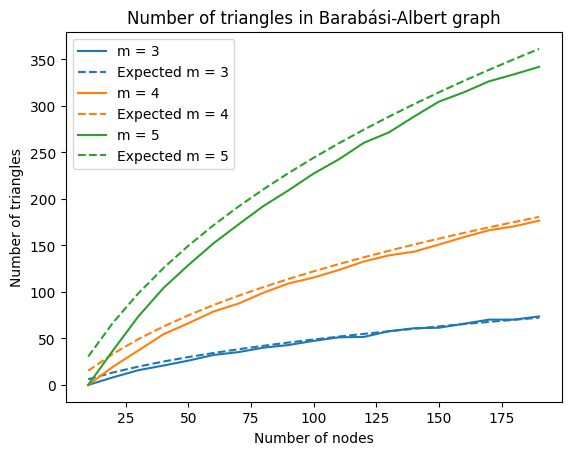

In [25]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

def k3_expected_number(n, m):
    return (m-1) * m * (m+1) * math.log(n)**3 / 48

for m in [3, 4, 5]:
    x = []
    y = []
    exp_y = []
    for n in range(10, 200, 10):
        print(n)
        ex = k3_expected_number(n, m)
        n_sum = 0
        for _ in range(100):
            G = generate_graph(10, n, m)
            triangles = nx.triangles(G)
            total_triangles = sum(triangles.values()) // 3
            n_sum += total_triangles
        x.append(n)
        y.append(n_sum / 100)
        exp_y.append(ex)
    
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of triangles in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of triangles")
plt.legend()
plt.show()


10
110
210
310
410
510
610
710
810
910
1010
1110
1210
1310
1410
1510
1610
1710
1810
1910
2010
2110
2210
2310
2410
2510
2610
2710
2810
2910
3010
3110
3210
3310
3410
3510
3610
3710
3810
3910
4010
4110
4210
4310
4410
4510
4610
4710
4810
4910
10
110
210
310
410
510
610
710
810
910
1010
1110
1210
1310
1410
1510
1610
1710
1810
1910
2010
2110
2210
2310
2410
2510
2610
2710
2810
2910
3010
3110
3210
3310
3410
3510
3610
3710
3810
3910
4010
4110
4210
4310
4410
4510
4610
4710
4810
4910


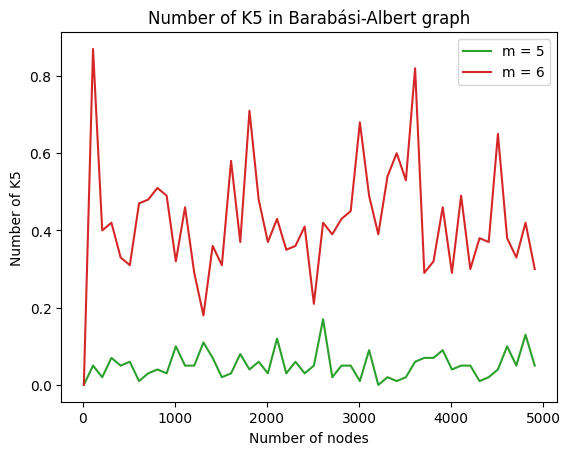

In [121]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

def k5_expected_number(n, m):
    return m**5 * math.log(n)**3 / 3840

for m in [5, 6]:
    x = []
    y = []
    exp_y = []
    for n in range(10, 5000, 100):
        print(n)
        # ex = k5_expected_number(n, m)
        n_sum = 0
        for _ in range(10):
            G = generate_graph(10, n, m)
            cliques = list(nx.enumerate_all_cliques(G))
            k5_cliques = [clique for clique in cliques if len(clique) == 5]
            n_sum += len(k5_cliques)
        x.append(n)
        y.append(n_sum / 100)
        # exp_y.append(ex)
    
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    pickle.dump((x, y), open(f'k5_data_m_{m}_large.pkl', 'wb'))
    # plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K5 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K5")
plt.legend()
plt.show()


In [1]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

def k5_expected_number(n, m):
    return m**5 * math.log(n)**5 / 38400

for m in [5, 6]:
    (xs, ys) = pickle.load(open(f'k5_data_m_{m}.pkl', 'rb'))
    r = [y for x, y in zip(xs, ys)]
    plt.plot(xs, r, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    # exp = [k5_expected_number(n, m) for n in xs]
    # plt.plot(xs, ys, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    # plt.plot(xs, exp, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of K5 in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of K5")
plt.legend()
plt.show()


NameError: name 'pickle' is not defined

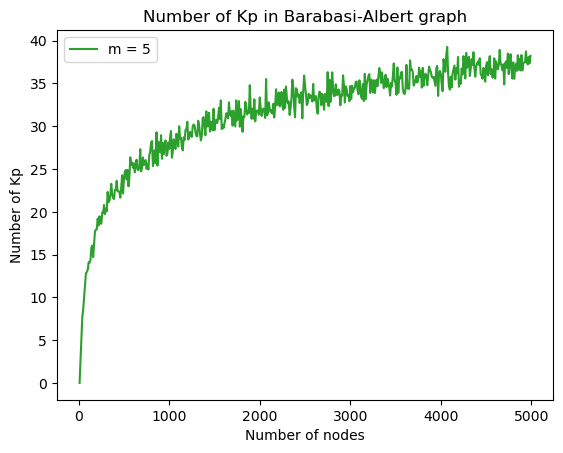

In [44]:
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

p = 4
c = 300000
reps = 10

def kp_expected_number(p, n, m, c):
    return (m**p) * (math.log(n)**p) / c

for m in [5]:
    x = []
    y = []
    exp_y = []
    for n in range(10, 5000, 10):
        ex = kp_expected_number(p, n, m, c)
        n_sum = 0
        for _ in range(reps):
            G = generate_graph(10, n, m)
            cycles = nx.cycle_basis(G)
            total_cycles = len([cycle for cycle in cycles if len(cycle) == p])
            n_sum += total_cycles / p
        x.append(n)
        y.append(n_sum / reps)
        exp_y.append(ex)
    
    plt.plot(x, y, label=f'm = {m}', linestyle='-', color=COLORS[m - 3])
    pickle.dump((x, y), open(f'kp_data_m_{m}_xyz.pkl', 'wb'))
    # plt.plot(x, exp_y, label=f'Expected m = {m}', linestyle='--', color=COLORS[m - 3])
plt.title("Number of Kp in Barabasi-Albert graph")
plt.xlabel("Number of nodes")
plt.ylabel("Number of Kp")
plt.legend()
plt.show()


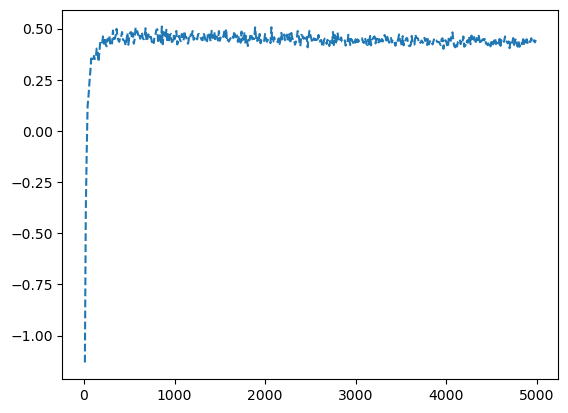

In [64]:
(xs, ys) = pickle.load(open(f'kp_data_m_{5}_xyz.pkl', 'rb'))
es = [(y-6) / math.log(x) / math.log(x) for (x, y) in zip(xs, ys)]
# plt.plot(xs, ys, linestyle='-')
plt.plot(xs, es, linestyle='--')
plt.show()

In [27]:
def has_cycle_of_length_n(graph, n):
    def dfs(node, visited, path):
        visited.add(node)
        path.append(node)

        if len(path) > n:
            visited.remove(node)
            path.pop()
            return False

        for neighbor in graph.get(node, []):
            if neighbor == path[0] and len(path) == n:
                return True
            if neighbor not in visited:
                if dfs(neighbor, visited, path):
                    return True

        visited.remove(node)
        path.pop()
        return False

    for node in graph:
        if dfs(node, set(), []):
            return True

    return False

def has_clique_of_size_n(graph, n):
    if len(graph.keys()) != n:
        return False
    
    for _, value in graph.items():
        if len(value) != n-1:
            return False
        
    return True

def test(V, E, check):
    groups = [
        [chr(ord('A') + i)] for i in range(V)
    ]

    group_pairs = list(combinations(range(len(groups)), 2))

    all_edges = []
    for (i, j) in group_pairs:
        for node1, node2 in product(groups[i], groups[j]):
            all_edges.append((node1, node2))

    sorted_all_edges = []
    for edge in all_edges:
        if edge[0][0] > edge[1][0]:
            sorted_all_edges.append(edge)
        else:
            sorted_all_edges.append((edge[1], edge[0]))

    edges_groups = list(combinations(sorted_all_edges, E))

    counter = 0
    for group in edges_groups:
        graph = {chr(ord('A') + i) : [] for i in range(V)}
        for edge in group:
            e1 = edge[0][0]
            e2 = edge[1][0]
            graph[e1].append(e2)
            graph[e2].append(e1)

        if check(graph, V):
            counter += 1
    print(counter)

test(6, 6, has_cycle_of_length_n)
test(5, 10, has_clique_of_size_n)

60
1
